In [83]:
import time
import tqdm
import os
import gc
from collections import deque

import gym
import pybullet_envs

import pathlib

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.tensorboard import SummaryWriter
import yaml

In [3]:
from ast import literal_eval

a = '[34]'
b = '[101]'
c = '[0]'

l = literal_eval(a)
l[0]

34

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


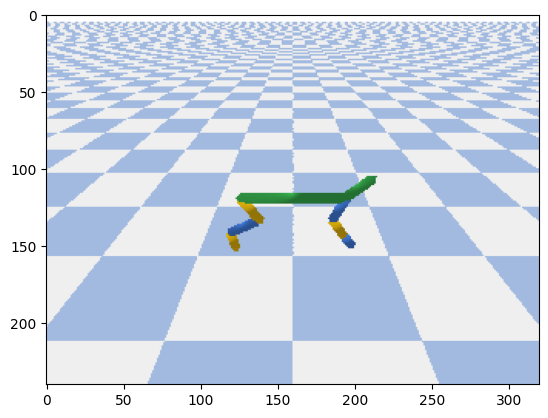

In [3]:
env = gym.make('HalfCheetahBulletEnv-v0')  # 環境を読み込む.
env.reset()
image = env.render(mode='rgb_array')  # env.renderで画像を取得
plt.imshow(image)
plt.show()
env.close()

In [4]:
class GymWrapper_PyBullet(object):
    """
    PyBullet環境のためのラッパー
    """
    metadata = {'render.modes': ['human', 'rgb_array']}
    reward_range = (-np.inf, np.inf)

    # __init__でカメラ位置に関するパラメータ( cam_dist:カメラ距離, cam_yaw：カメラの水平面での回転, cam_pitch:カメラの縦方向での回転)を受け取り, カメラの位置を調整できるようにします.
    #　同時に画像の大きさも変更できるようにします
    def __init__(self, env, cam_dist=3, cam_yaw=0, cam_pitch=-30, render_width=320, render_height=240):
        self._env = env
        self._env.env._cam_dist = cam_dist
        self._env.env._cam_yaw = cam_yaw
        self._env.env._cam_pitch = cam_pitch
        self._env.env._render_width = render_width
        self._env.env._render_height = render_height

    def __getattr(self, name):
        return getattr(self._env, name)

    @property
    def observation_space(self):
        width = self._env.env._render_width
        height = self._env.env._render_height
        return gym.spaces.Box(0, 255, (height, width, 3), dtype=np.uint8)

    @property
    def action_space(self):
        return self._env.action_space

    #　元の観測（低次元の状態）は今回は捨てて, env.render()で取得した画像を観測とします.
    #  画像, 報酬, 終了シグナルが得られます.
    def step(self, action):
        _, reward, done, info = self._env.step(action)
        obs = self._env.render(mode="rgb_array")
        return obs, reward, done, info

    def reset(self):
        self._env.reset()
        obs = self._env.render(mode="rgb_array")
        return obs

    def render(self, mode='human', **kwargs):
        return self._env.render(mode, **kwargs)

    def close(self):
        self._env.close()

In [5]:
env = gym.make('HalfCheetahBulletEnv-v0')
# カメラのパラメータを与えてカメラの位置と角度, 画像の大きさを調整
env = GymWrapper_PyBullet(env, cam_dist=2, cam_pitch=0, render_width=64, render_height=64)

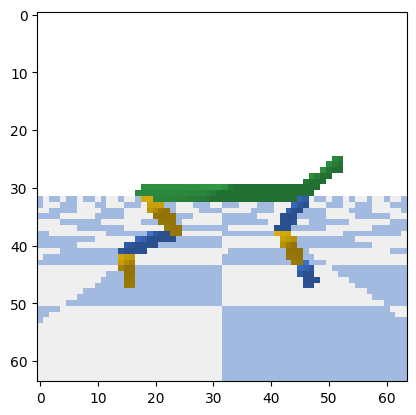

In [6]:
env.reset()
image = env.render(mode='rgb_array')
plt.imshow(image)
plt.show()
env.close()

In [7]:
class RepeatAction(gym.Wrapper):
    """
    同じ行動を指定された回数自動的に繰り返すラッパー. 観測は最後の行動に対応するものになる
    """
    def __init__(self, env, skip=4):
        gym.Wrapper.__init__(self, env)
        self._skip = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        total_reward = 0.0
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

In [8]:
def make_env():
    env = gym.make('HalfCheetahBulletEnv-v0')  # 環境を読み込む. 今回はHalfCheetah
    # Dreamerでは観測は64x64のRGB画像
    env = GymWrapper_PyBullet(env, cam_dist=2, cam_pitch=0, render_width=64, render_height=64)
    env = RepeatAction(env, skip=2)  # DreamerではActionRepeatは2
    return env

In [79]:
class TransitionModel(nn.Module):
    def __init__(self, state_dim, action_dim, rnn_hidden_dim, hidden_dim=200, min_stddev=0.1, act=F.relu):
        super(TransitionModel, self).__init__()

        # 状態，行動，RNNの隠れ層の次元を決める
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.rnn_hidden_dim = rnn_hidden_dim
        self.fc_state_action = nn.Linear(state_dim + action_dim, hidden_dim)

        self.fc_rnn_hidden = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc_state_mean_prior = nn.Linear(hidden_dim, state_dim)
        self.fc_state_stddev_prior = nn.Linear(hidden_dim, state_dim)
        self.fc_rnn_hidden_embedded_obs = nn.Linear(rnn_hidden_dim + 1024, hidden_dim)

        self.fc_state_mean_posterior = nn.Linear(hidden_dim, state_dim)
        self.fc_state_stddev_posterior = nn.Linear(hidden_dim, state_dim)

        # next hidden stateを計算
        self.rnn = nn.GRUCell(hidden_dim, rnn_hidden_dim)
        self._min_stddev = min_stddev
        self.act = act

    def forward(self, state, action, rnn_hidden, embedded_next_obs):
        """
        h_t+1 = f(h_t, s_t, a_t)
        prior p(s_t+1 | h_t+1) と posterior q(s_t+1 | h_t+1, e_t+1) を返す
        この2つが近づくように学習する
        """
        next_state_prior, rnn_hidden = self.prior(self.recurrent(state, action, rnn_hidden))
        next_state_posterior = self.posterior(rnn_hidden, embedded_next_obs)
        return next_state_prior, next_state_posterior, rnn_hidden

    def recurrent(self, state, action, rnn_hidden):
        """
        h_t+1 = f(h_t, s_t, a_t)を計算する
        """
        hidden = self.act(self.fc_state_action(torch.cat([state, action], dim=1)))
        #h_t+1を求める
        rnn_hidden = self.rnn(hidden, rnn_hidden)
        return rnn_hidden

    def prior(self, rnn_hidden):
        """
        prior p(s_t+1 | h_t+1) を計算する
        """
        #h_t+1を求める
        hidden = self.act(self.fc_rnn_hidden(rnn_hidden))

        mean = self.fc_state_mean_prior(hidden)
        stddev = F.softplus(self.fc_state_stddev_prior(hidden)) + self._min_stddev
        return Normal(mean, stddev), rnn_hidden

    def posterior(self, rnn_hidden, embedded_obs):
        """
        posterior q(s_t+1 | h_t+1, e_t+1)  を計算する
        """
        # h_t+1, o_t+1を結合し, q(s_t+1 | h_t+1, e_t+1) を計算する
        hidden = self.act(self.fc_rnn_hidden_embedded_obs(torch.concat([rnn_hidden, embedded_obs], dim=1)))
        mean = self.fc_state_mean_posterior(hidden)
        stddev = F.softplus(self.fc_state_stddev_posterior(hidden)) + self._min_stddev
        return Normal(mean, stddev)

In [10]:
class ObservationModel(nn.Module):
    """
    p(o_t | s_t, h_t)
    低次元の状態表現から画像を再構成するデコーダ (3, 64, 64)
    """
    def __init__(self, state_dim, rnn_hidden_dim):
        super(ObservationModel, self).__init__()
        self.fc = nn.Linear(state_dim + rnn_hidden_dim, 1024)
        self.dc1 = nn.ConvTranspose2d(1024, 128, kernel_size=5, stride=2)
        self.dc2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2)
        self.dc3 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2)
        self.dc4 = nn.ConvTranspose2d(32, 3, kernel_size=6, stride=2)


    def forward(self, state, rnn_hidden):
        hidden = self.fc(torch.cat([state, rnn_hidden], dim=1))
        hidden = hidden.view(hidden.size(0), 1024, 1, 1)
        hidden = F.relu(self.dc1(hidden))
        hidden = F.relu(self.dc2(hidden))
        hidden = F.relu(self.dc3(hidden))
        obs = self.dc4(hidden)
        return obs

In [11]:
class RewardModel(nn.Module):
    """
    p(r_t | s_t, h_t)
    低次元の状態表現から報酬を予測する
    """
    def __init__(self, state_dim, rnn_hidden_dim, hidden_dim=400, act=F.elu):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.act = act

    def forward(self, state, rnn_hidden):
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        reward = self.fc4(hidden)
        return reward

In [12]:
class RSSM:
    def __init__(self, state_dim, action_dim, rnn_hidden_dim, device):
        self.transition = TransitionModel(state_dim, action_dim, rnn_hidden_dim).to(device)
        self.observation = ObservationModel(state_dim, rnn_hidden_dim, ).to(device)
        self.reward = RewardModel(state_dim, rnn_hidden_dim, ).to(device)


In [13]:
"""
DQNの訓練時のReplayBufferの定義
"""
class ReplayBuffer:
    def __init_(self, memory_size: int):
        self.memory_size = memory_size
        self.memory = deque([], maxlen = memory_size)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        batch_index = np.random.randint(0, len(self.memory), size=batch_size)
        states = np.array([self.memory[index]['state'] for index in batch_index])
        next_states = np.array([self.memory[index]['next_state'] for index in batch_index])
        rewards = np.array([self.memory[index]['rewards'] for index in batch_index])
        actions = np.array([self.memory[index]['actions'] for index in batch_index])
        dones = np.array([self.memory[index]['done'] for index in batch_index])
        return {'states': states, 'next_states': next_states, 'rewards': rewards, 'actions': actions, 'dones': dones}

In [38]:
"""
今回のReplayBufferの定義
"""
class ReplayBuffer(object):
    def __init__(self, capacity, observation_shape, action_dim):
        # length of chunk
        self.capacity = capacity

        self.observations = np.zeros((capacity, *observation_shape), dtype=np.uint8)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=np.bool_)

        self.index = 0
        self.is_filled = False

    def push(self, observation, action, reward, done):
        """Add an experiences to replay buffer
        Args:
            observation:
            action:
            reward:
            done:

        Returns:
        """

        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.done[self.index] = done

        if self.index == self.capacity -1:
            self.is_filled = True
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size, chunk_length):
        """Sample an experience from replay buffer.
        Args:
            batch_size:
            chunk_length:

        Returns:
            experiences -> Array: [batch_size, chunk_length, dimensions] for each of {observation, action, reward, dones}
        """
        assert len(self) > 0, "Replay buffer is empty."
        assert len(self) > chunk_length

        # index of episode finished
        episode_borders = np.where(self.done)[0]
        sampled_indexes = []
        for _ in range(batch_size):

            #  Checking chunks to see if they cross episodes
            cross_border = True
            while cross_border:
                initial_index = np.random.randint(len(self) - chunk_length + 1)
                final_index = initial_index + chunk_length - 1
                cross_border = np.logical_and(initial_index <= episode_borders, episode_borders < final_index).any()
            sampled_indexes += list(range(initial_index, final_index + 1))

        sampled_observations = self.observations[sampled_indexes].reshape(
            batch_size, chunk_length, *self.observations.shape[1:]
        )
        sampled_actions = self.actions[sampled_indexes].reshape(
            batch_size, chunk_length, self.actions.shape[1]
        )
        sampled_rewards = self.rewards[sampled_indexes].reshape(
            batch_size, chunk_length, 1
        )
        sampled_done = self.done[sampled_indexes].reshape(
            batch_size, chunk_length, 1
        )

        return sampled_observations, sampled_actions, sampled_rewards, sampled_done


    def __len__(self):
        return self.capacity if self.is_filled else self.index

In [39]:
def preprocess_obs(obs):
    """Transform observations
    Args:
        obs: observations
    Returns:
        transformed observations
    """
    obs = obs.astype(np.float32)
    normalized_obs = obs / 255. - 0.5
    return normalized_obs

In [40]:
def lambda_target(rewards, values, gamma, lambda_):
    """Calculate λ-return to update value function
    Args:
        rewards:
        values:
        gamma:
        lambda_:

    Returns:
    """
    V_lambda = torch.zeros_like(rewards, device=rewards.device)

    H = rewards.shape[0] - 1
    V_n = torch.zeros_like(rewards, device=rewards.device)
    V_n[H] = values[H]
    for n in range(1, H+1):
        V_n[:-n] = (gamma ** (n-1)) * values[n:]
        for k in range(1, n+1):
            if k == n:
                V_n[:-n] += (gamma ** (n-1)) * rewards[k:]
            else:
                V_n[:-n] += (gamma ** (k-1)) * rewards[k:-n+k]

        if n == H:
            V_lambda += (lambda_ ** (H-1)) * V_n
        else:
            V_lambda += (1 - lambda_) * (lambda_ ** (n - 1)) * V_n

    return V_lambda

In [41]:
class Encoder(nn.Module):
    """Encode observations to embedding vectors
    """
    def __init__(self):
        super(Encoder, self).__init__()
        self.cv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2)
        self.cv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.cv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.cv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2)

    def forward(self, obs):
        """
        Args:
            obs: Image batch (batch_size, 3, 64, 64)

        Returns:
            embedded_obs: (batch_size, 1024)
        """
        hidden = F.relu(self.cv1(obs))
        hidden = F.relu(self.cv2(hidden))
        hidden = F.relu(self.cv3(hidden))
        embedded_obs = F.relu(self.cv4(hidden)).reshape(hidden.size(0), -1)
        return embedded_obs

In [49]:
class ValueModel(nn.Module):
    """
    V(s, h)
    """
    def __init__(self, state_dim, rnn_hidden_dim, hidden_dim=400, act=F.relu):
        super(ValueModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

        self.act = act

    def forward(self, state, rnn_hidden):
        hidden = self.act(self.fc1(torch.concat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        state_value = self.fc4(hidden)
        return state_value

In [43]:
class ActionModel(nn.Module):
    """
    Determine action from low-dimensional state representation.
    p(a_t | s_t, h_t)
    """
    def __init__(self, state_dim, rnn_hidden_dim, action_dim,
                 hidden_dim=400, act=F.relu, min_stddev=1e-4, init_stddev=5.0):
        super(ActionModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, action_dim)
        self.fc_stddev = nn.Linear(hidden_dim, action_dim)

        self.act = act
        self.min_stddev = min_stddev
        self.init_stddev = init_stddev

    def forward(self, state, rnn_hidden, training=True):

        hidden = self.act(self.fc1(torch.concat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        hidden = self.act(self.fc4(hidden))

        mean = self.fc_mean(hidden)
        mean = 5.0 * torch.tanh(mean / 5.0)
        stddev = self.min_stddev + self.fc_stddev(hidden)
        stddev = F.softplus(stddev + self.init_stddev) + self.min_stddev

        if training:
            action = torch.tanh(Normal(mean, stddev).rsample())
        else:
            action = torch.tanh(mean)
        return action

In [70]:
class Agent:
    """
    Determine action based on ActionModel. Agent retain rnn_hidden for predict state from observation.
    s_t+1 ~ q(s_t|o_t, h_t)
    a_t+1 ~ p(a_t+1|h_t, s_t)
    h_t+1 = f(h_t, s_t, a_t)
    """
    def __init__(self, encoder, rssm, action_model):
        self.encoder = encoder
        self.rssm = rssm
        self.action_model = action_model

        self.device = next(self.action_model.parameters()).device
        self.rnn_hidden = torch.zeros(1, rssm.rnn_hidden_dim, device=self.device)

    def __call__(self, obs, training=True):
        # preprocessing observation
        obs = preprocess_obs(obs)
        obs = torch.as_tensor(obs, device=self.device)

        # (H, W, C) -> (1, C, H, W)
        obs = obs.transpose(1, 2).transpose(0, 1).unsqueeze(0)

        with torch.no_grad():
            # encode observation & determine action
            embedded_obs = self.encoder(obs)
            state_posterior = self.rssm.posterior(self.rnn_hidden, embedded_obs)
            state = state_posterior.rsample()
            action = self.action_model(state, self.rnn_hidden)

            # predict next rnn_hidden_state
            _, self.rnn_hidden = self.rssm.prior(self.rssm.recurrent(state, action, self.rnn_hidden))

        return action.squeeze().cpu().numpy()

    def reset(self):
        self.rnn_hidden = torch.zeros(1, self.rssm.rnn_hidden_dim, device=self.device)

In [80]:
buffer_capacity = 200000

observation_shape = env.observation_space.shape
action_dim = env.action_space.shape[0]

replay_buffer = ReplayBuffer(
    capacity=buffer_capacity,
    observation_shape=observation_shape,
    action_dim=action_dim
)

state_dim = 30
rnn_hidden_dim = 200

encoder = Encoder().to(device)
rssm = RSSM(
    state_dim,
    action_dim,
    rnn_hidden_dim,
    device
)
value_model = ValueModel(
    state_dim,
    rnn_hidden_dim
).to(device)
action_model = ActionModel(
    state_dim,
    rnn_hidden_dim,
    action_dim
).to(device)

model_lr = 6e-4  ## too little??
value_lr = 8e-5
action_lr = 8e-5
eps = 1e-4
model_params = (
    list(encoder.parameters()) +
    list(rssm.transition.parameters()) +
    list(rssm.observation.parameters()) +
    list(rssm.reward.parameters())
)

model_optimizer = torch.optim.Adam(model_params, lr=model_lr, eps=eps)
value_optimizer = torch.optim.Adam(value_model.parameters(), lr=value_lr, eps=eps)
action_optimizer = torch.optim.Adam(action_model.parameters(), lr=action_lr, eps=eps)

seed_episodes = 5  # number of episode for random action
all_episodes = 100  # number of episode for all training
test_interval = 10  # test interval (test is conducted without noisy action)
model_save_interval = 20  # save interval for saving model
collect_interval = 100  #

action_noise_var = 0.3  # exploration

batch_size = 50
chunk_length = 50
imagination_horizon = 15

gamma = 0.9
lambda_ = 0.95
clip_grad_norm = 100
free_nats = 3

In [67]:
env = make_env()
for episode in tqdm.tqdm(range(seed_episodes)):
    obs = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        next_obs, reward, done, _ = env.step(action)
        replay_buffer.push(obs, action, reward, done)
        obs = next_obs

100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


In [68]:
log_dir = pathlib.Path(os.getcwd()).parent / pathlib.Path('log_dir')
log_dir.mkdir(exist_ok=True)
writer = SummaryWriter(log_dir)

In [81]:
for episode in range(seed_episodes, all_episodes):
    # 1. Collect experiences
    start = time.time()
    policy = Agent(encoder, rssm.transition, action_model)

    env = make_env()
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = policy(obs)
        # Add gaussian noise for exploration
        action += np.random.normal(0, np.sqrt(action_noise_var), env.action_space.shape[0])
        next_obs, reward, done, _ = env.step(action)

        # Save {obs, action, reward, done} to replay buffer
        replay_buffer.push(obs, action, reward, done)

        obs = next_obs
        total_reward += reward

    # Write reward and elapsed time to Tensorboard
    writer.add_scalar('total reward at train', total_reward, episode)
    print('episode [%4d/%4d] is collected. Total reward is %f' %
          (episode+1, all_episodes, total_reward))
    print('elapsed time for interaction: %.2fs' % (time.time() - start))

    # 2. Update NN parameters
    start = time.time()
    for update_step in range(collect_interval):
        # 2.1 Dynamics learning
        observations, actions, rewards, _ = \
            replay_buffer.sample(batch_size, chunk_length)

        observations = preprocess_obs(observations)
        observations = torch.as_tensor(observations, device=device)

        # (B, L, H, W, C) -> (B, L, C, H, W). L: Chunk length
        observations = observations.transpose(3, 4).transpose(2, 3)
        # (B, L, H, W, C) -> (L, B, C, H, W)
        observations = observations.transpose(0, 1)

        # (B, L, Action_dim) -> (L, B, Action_dim)
        # (B, L, 1) -> (L, B, 1)
        actions = torch.as_tensor(actions, device=device).transpose(0, 1)
        rewards = torch.as_tensor(rewards, device=device).transpose(0, 1)

        # (L, B, C, H, W) -> (L*B, C, H, W) -> (L, B, Encoded_dim)
        embedded_obs = encoder(
            observations.reshape(-1, 3, 64, 64)
        ).view(chunk_length, batch_size, -1)

        states = torch.zeros(chunk_length, batch_size, state_dim, device=device)
        rnn_hiddens = torch.zeros(chunk_length, batch_size, rnn_hidden_dim, device=device)

        # Initialize init state(s_0) with 0
        state = torch.zeros(states.shape[1:], device=device)
        rnn_hidden = torch.zeros(rnn_hiddens.shape[1:], device=device)

        # Compute KL divergence between prior and posterior
        kl_loss = 0
        for l in range(chunk_length - 1):
            next_state_prior, next_state_posterior, rnn_hidden = \
                rssm.transition(state, actions[l], rnn_hidden, embedded_obs[l+1])
            state = next_state_posterior.rsample()
            states[l+1] = state
            rnn_hiddens[l+1] = rnn_hidden

            # -> (batch_size)
            kl = kl_divergence(next_state_posterior, next_state_prior)
            kl_loss += kl.clamp(min=free_nats).mean()
        kl_loss /= (chunk_length - 1)

        # Discord stats[0] and rnn_hidden[0] because these are initialized 0.
        states = states[1:]
        rnn_hiddens = rnn_hidden[1:]

        # Reconstruct observations and Predict rewards
        # -> (L*B, state_dim), -> (L*B, rnn_hidden_dim)  ## ここ違うかも
        flatten_states = states.view(-1, state_dim)
        flatten_rnn_hiddens = rnn_hiddens.view(-1, rnn_hidden_dim)
        # -> (L, B, C, H, W), -> (L, B, 1)
        recon_observations = rssm.observation(flatten_states, flatten_rnn_hiddens).view(chunk_length, batch_size, 3, 64, 64)
        predicted_rewards = rssm.reward(flatten_states, flatten_rnn_hiddens).view(chunk_length - 1, batch_size, 1)

        # Calculate prediction error with observations and rewards
        obs_loss = 0.5 * F.mse_loss(recon_observations, observations[1:], reduction='none').mean([0, 1]).sum()
        reward_loss = 0.5 * F.mse_loss(predicted_rewards, rewards[:-1])

        # Update nn parameters(dynamics)
        model_loss = kl_loss + obs_loss + reward_loss
        model_optimizer.zero_grad()
        model_loss.backward()
        clip_grad_norm_(model_params, clip_grad_norm)
        model_optimizer.step()


        # 2.2 Behavior learning(Actor-critic)
        # detach parameters of transition_model
        flatten_states = flatten_states.detach()
        flatten_rnn_hiddens = flatten_rnn_hiddens.detach()

        # Prepare a Tensor to hold future state predictions several steps ahead
        imaginated_states = torch.zeros(imagination_horizon + 1, *flatten_states.shape, device=flatten_states.device)
        imaginated_rnn_hiddens = torch.zeros(imagination_horizon + 1, *flatten_rnn_hiddens.shape, device=rnn_hidden.device)

        # Before creating imaginated trajectory, the initial state is the one we just used to update model parameters.(State on observations sampled from replay buffer)
        imaginated_states[0] = flatten_states
        imaginated_rnn_hiddens[0] = flatten_rnn_hiddens

        # Create imaginated trajectory
        for h in range(1, imagination_horizon + 1):
            actions = action_model(flatten_states, flatten_rnn_hiddens)
            flatten_states_prior, flatten_rnn_hiddens = rssm.transition.prior(rssm.transition.recurrent(flatten_states,
                                                                                                        actions,
                                                                                                        flatten_rnn_hiddens))
            flatten_states = flatten_states_prior.rsample()
            imaginated_states[h] = flatten_states
            imaginated_rnn_hiddens[h] = flatten_rnn_hiddens

        # Calculate rewards and values on imaginated trajectory.
        flatten_imaginated_states = imaginated_states.view(-1, state_dim)
        flatten_imaginated_rnn_hiddens = imaginated_rnn_hiddens.view(-1, rnn_hidden_dim)
        imaginated_rewards = \
            rssm.reward(flatten_imaginated_states,
                        flatten_imaginated_rnn_hiddens).view(imagination_horizon + 1, -1)
        imaginated_values = \
            value_model(flatten_imaginated_rnn_hiddens,
                        flatten_imaginated_rnn_hiddens).view(imagination_horizon + 1, -1)

        lambda_target_values = lambda_target(imaginated_rewards, imaginated_values, gamma, lambda_)

        # Update action model(Actor)
        action_loss = -1 * lambda_target_values.mean()
        action_optimizer.zero_grad()
        action_loss.backward()
        clip_grad_norm_(action_model.parameters(), clip_grad_norm)
        action_optimizer.step()

        # Update value model(Critic)
        imaginated_values = value_model(flatten_imaginated_states.detach(), flatten_imaginated_rnn_hiddens.detach()).view(imagination_horizon + 1, -1)
        value_loss = 0.5 * F.mse_loss(imaginated_values, lambda_target_values)
        value_optimizer.zero_grad()
        value_loss.backward()
        clip_grad_norm_(value_model.parameters(), clip_grad_norm)
        value_model.step()

        # Output log to TensorBoard
        print('update_step: %3d model loss: %.5f, kl_loss: %.5f, '
              'obs_loss: %.5f, reward_loss: %.5f, '
              'value_loss: %.5f action_loss: %.5f'
              % (update_step + 1, model_loss.item(), kl_loss.item(),
                 obs_loss.item(), reward_loss.item(),
                 value_loss.item(), action_loss.item()))
        total_update_step = episode * collect_interval + update_step
        writer.add_scalar('model loss', model_loss.item(), total_update_step)
        writer.add_scalar('kl loss', kl_loss.item(), total_update_step)
        writer.add_scalar('obs loss', obs_loss.item(), total_update_step)
        writer.add_scalar('reward loss', reward_loss.item(), total_update_step)
        writer.add_scalar('value loss', value_loss.item(), total_update_step)
        writer.add_scalar('action loss', action_loss.item(), total_update_step)

    print('elapsed time for update: %.2f[s]' % (time.time() - start))


    # 3. Evaluate once every {test_interval} episodes.
    if (episode + 1) % test_interval == 0:
        policy = Agent(encoder, rssm.transition, action_model)
        start = time.time()
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = policy(obs, training=False)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

        writer.add_scalar('total reward at test', total_reward, episode)
        print('Total test reward at episode[%4d/%4d]: %f' % (episode + 1, all_episodes, total_reward))
        print('Elapsed time: %.2f[s]' % (time.time() - start))

    # 4. Save once every {model_save_interval} episodes.
    if (episode + 1) % model_save_interval == 0:
        model_log_dir = log_dir / f'episode_{(episode + 1):04d}'
        model_log_dir.mkdir(exist_ok=True)
        torch.save(encoder.state_dict(), model_log_dir / 'encoder.pth')
        torch.save(rssm.transition.state_dict(), model_log_dir / 'rssm.pth')
        torch.save(rssm.observation.state_dict(), model_log_dir / 'obs_model.pth')
        torch.save(value_model.state_dict(), model_log_dir / 'value_model.pth')
        torch.save(action_model.state_dict(), model_log_dir / 'action_model.pth')
    del env
    gc.collect()
writer.close()

episode [   6/ 100] is collected. Total reward is -1662.881157
elapsed time for interaction: 3.86s


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 2450 but got size 49 for tensor number 1 in the list.